In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [35]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=100

In [36]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/intern/katunda_dataset/full_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6266 files belonging to 6 classes.


In [37]:
class_names = dataset.class_names
class_names

['Fruit_Brownspot',
 'Fruit_Healthy',
 'Fruit_Woodiness',
 'Leaves_Brownspot',
 'Leaves_Healthy',
 'Leaves_Woodiness']

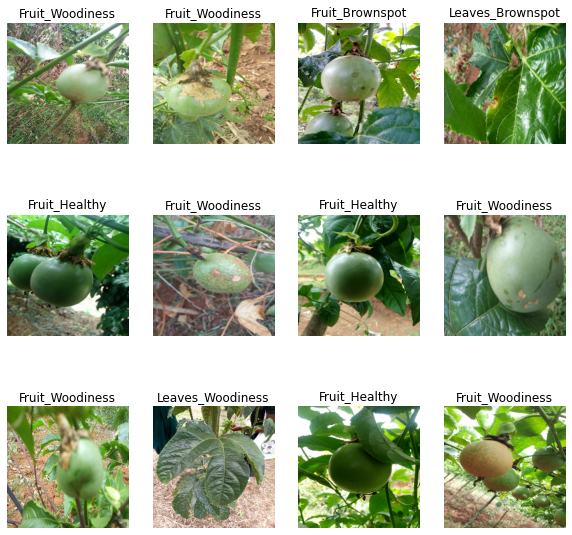

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [38]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [39]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

156
19
21


In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

156
19
21


In [43]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                  

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
156/156 [==============================] - 75s 278ms/step - loss: 1.5452 - accuracy: 0.3203 - val_loss: 1.3316 - val_accuracy: 0.4490
Epoch 2/100
156/156 [==============================] - 9s 56ms/step - loss: 1.3063 - accuracy: 0.4469 - val_loss: 1.2675 - val_accuracy: 0.4720
Epoch 3/100
156/156 [==============================] - 9s 56ms/step - loss: 1.1961 - accuracy: 0.5056 - val_loss: 1.1615 - val_accuracy: 0.4967
Epoch 4/100
156/156 [==============================] - 8s 54ms/step - loss: 0.9191 - accuracy: 0.6432 - val_loss: 0.9751 - val_accuracy: 0.6398
Epoch 5/100
156/156 [==============================] - 8s 54ms/step - loss: 0.7905 - accuracy: 0.7008 - val_loss: 0.7198 - val_accuracy: 0.7303
Epoch 6/100
156/156 [==============================] - 8s 54ms/step - loss: 0.6951 - accuracy: 0.7379 - val_loss: 0.6316 - val_accuracy: 0.7780
Epoch 7/100
156/156 [==============================] - 8s 54ms/step - loss: 0.6097 - accuracy: 0.7724 - val_loss: 0.7115 - val_accurac

In [49]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 36s 26ms/step - loss: 0.1499 - accuracy: 0.9583


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

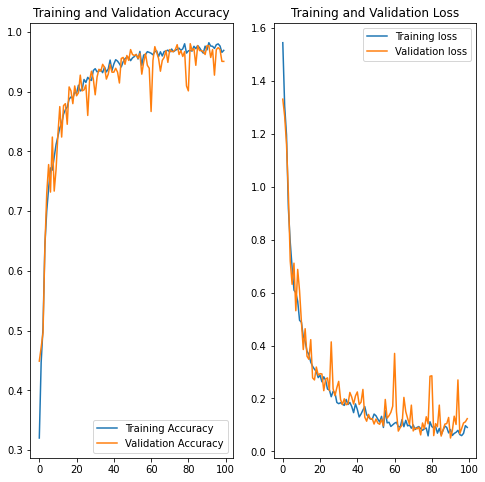

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [52]:
import os
os.chdir('/content/drive/MyDrive/intern')

In [53]:
model.save("saved_models/joint_leaves_fruits_classification_model")

INFO:tensorflow:Assets written to: saved_models/joint_leaves_fruits_classification_model/assets


INFO:tensorflow:Assets written to: saved_models/joint_leaves_fruits_classification_model/assets


In [54]:
model.save("saved_models/joint_leaves_fruits_classification_model.h5")

first image to predict
actual label: Fruit_Brownspot
[3.5687140e-01 5.4020726e-04 6.4258844e-01 3.1057421e-13 1.4729351e-11
 3.6329617e-09]
2
predicted label: Fruit_Woodiness


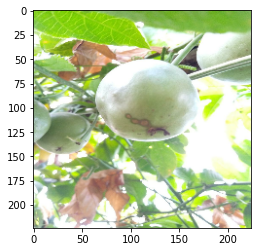

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [110]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

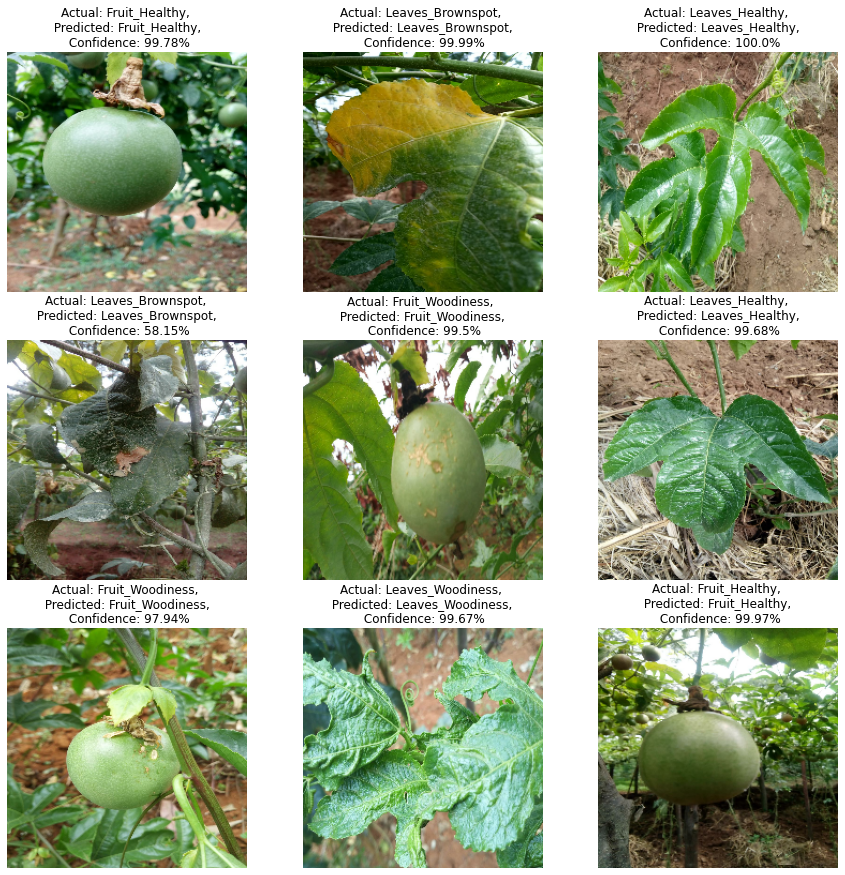

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as pyplot

In [59]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=pyplot.cm.Blues
):
    
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, "{:0.2f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [60]:
target_names = class_names

In [61]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [62]:
print("Confusion Matrix")
conf_matrix = confusion_matrix(correct_labels, predicted_labels)
print(conf_matrix)

Confusion Matrix
[[ 90   1   2   0   0   2]
 [  2 103   0   0   0   0]
 [  8   0 108   0   1   1]
 [  1   0   0 104   0   5]
 [  0   0   0   3 109   2]
 [  0   0   0   0   0 130]]


Confusion matrix, without normalization
[[ 90   1   2   0   0   2]
 [  2 103   0   0   0   0]
 [  8   0 108   0   1   1]
 [  1   0   0 104   0   5]
 [  0   0   0   3 109   2]
 [  0   0   0   0   0 130]]


<function matplotlib.pyplot.show>

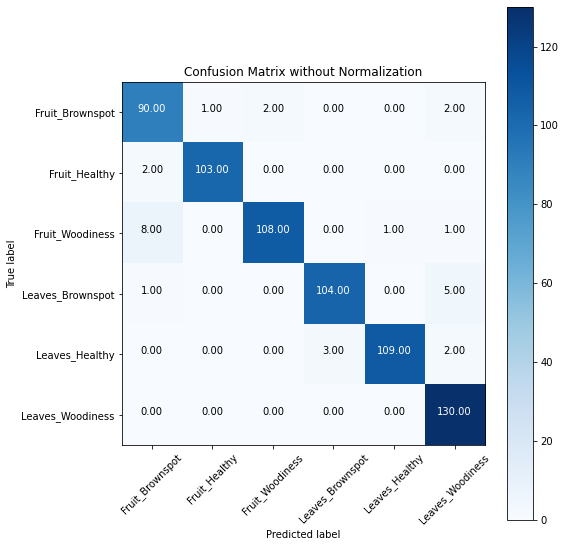

In [63]:
plt.figure(figsize=(8,8))
pyplot.figure(1)
plot_confusion_matrix(conf_matrix, classes=target_names, normalize=False, title="Confusion Matrix without Normalization")
pyplot.show

In [64]:
print(classification_report(correct_labels, predicted_labels, target_names=target_names))

                  precision    recall  f1-score   support

 Fruit_Brownspot       0.89      0.95      0.92        95
   Fruit_Healthy       0.99      0.98      0.99       105
 Fruit_Woodiness       0.98      0.92      0.95       118
Leaves_Brownspot       0.97      0.95      0.96       110
  Leaves_Healthy       0.99      0.96      0.97       114
Leaves_Woodiness       0.93      1.00      0.96       130

        accuracy                           0.96       672
       macro avg       0.96      0.96      0.96       672
    weighted avg       0.96      0.96      0.96       672



In [79]:
files = np.array(test_ds)
y_test = np.array(correct_labels)
predicted = np.array(predicted_labels)


wrong_predict = []
for order, value in enumerate(y_test):
  if y_test[order] != predicted[order].argmax():
    wrong_predict.append(order)
print(wrong_predict)


# wrong_class=[]
# # create a Boolean index for the wrong classifications
# for i in y_test, predicted:
#   if y_test != predicted:
#     wrong_class.append(y_test[i])

# wrong_class
# #classification_is_wrong = y_test != predicted

# # print the file names of the wrongly classified mails
# #print(files[classification_is_wrong])

[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 111, 112, 113, 114, 115, 116, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 187, 190, 191, 192, 193, 195, 196, 197, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 246, 247, 248, 250, 252, 253, 254, 255, 256, 257, 258, 259, 

In [81]:
y_test = np.array(correct_labels)
y_test

array([5, 5, 4, 4, 1, 0, 5, 0, 2, 5, 2, 5, 5, 3, 5, 5, 5, 5, 4, 1, 0, 0,
       2, 1, 0, 3, 5, 3, 3, 5, 2, 1, 5, 5, 2, 0, 3, 4, 4, 2, 5, 1, 1, 3,
       5, 2, 4, 3, 2, 4, 0, 2, 0, 4, 5, 0, 4, 2, 4, 5, 1, 4, 3, 1, 5, 4,
       0, 2, 5, 5, 0, 5, 5, 1, 4, 5, 0, 0, 4, 2, 3, 2, 5, 5, 4, 5, 4, 4,
       3, 3, 5, 0, 0, 1, 5, 1, 0, 0, 1, 5, 1, 4, 3, 4, 4, 4, 4, 0, 0, 2,
       0, 1, 2, 5, 2, 5, 1, 0, 0, 0, 1, 2, 5, 2, 5, 0, 4, 4, 5, 1, 5, 2,
       5, 1, 4, 4, 5, 5, 3, 0, 1, 2, 2, 0, 1, 3, 3, 2, 4, 0, 2, 2, 2, 0,
       2, 1, 3, 0, 2, 1, 5, 4, 3, 5, 2, 2, 4, 5, 4, 2, 5, 5, 3, 1, 4, 1,
       4, 4, 3, 4, 0, 1, 4, 1, 3, 3, 0, 3, 0, 0, 2, 3, 4, 5, 0, 5, 1, 1,
       0, 0, 1, 3, 3, 3, 2, 5, 2, 5, 1, 4, 0, 5, 1, 4, 2, 3, 1, 1, 3, 3,
       1, 5, 4, 1, 2, 2, 4, 2, 4, 5, 0, 2, 2, 2, 1, 5, 3, 2, 3, 5, 5, 0,
       5, 3, 1, 0, 3, 2, 1, 0, 3, 0, 4, 4, 1, 1, 1, 3, 4, 3, 2, 4, 2, 5,
       1, 3, 5, 4, 0, 4, 5, 5, 1, 4, 0, 0, 4, 4, 3, 5, 5, 3, 4, 5, 1, 5,
       4, 2, 2, 5, 3, 4, 3, 3, 0, 0, 2, 5, 2, 2, 1,

In [82]:
predicted = np.array(predicted_labels)
predicted

array([5, 5, 4, 4, 1, 0, 5, 0, 2, 5, 2, 5, 5, 3, 5, 5, 5, 5, 4, 1, 0, 0,
       0, 1, 0, 5, 5, 3, 3, 5, 5, 1, 5, 5, 2, 0, 3, 4, 4, 2, 5, 1, 1, 3,
       5, 2, 4, 3, 2, 4, 0, 2, 2, 4, 5, 0, 4, 2, 4, 5, 1, 4, 5, 1, 5, 4,
       0, 2, 5, 5, 0, 5, 5, 1, 4, 5, 1, 0, 4, 2, 3, 2, 5, 5, 4, 5, 4, 4,
       3, 3, 5, 0, 0, 1, 5, 1, 2, 0, 1, 5, 1, 4, 3, 4, 4, 4, 3, 0, 0, 2,
       0, 1, 2, 5, 2, 5, 1, 0, 0, 0, 1, 2, 5, 2, 5, 0, 4, 4, 5, 1, 5, 2,
       5, 1, 4, 4, 5, 5, 3, 0, 1, 2, 2, 0, 1, 3, 3, 2, 4, 0, 2, 2, 2, 0,
       2, 1, 3, 0, 2, 1, 5, 4, 3, 5, 2, 2, 4, 5, 4, 2, 5, 5, 3, 1, 4, 1,
       4, 4, 3, 4, 0, 1, 4, 1, 3, 3, 0, 3, 0, 0, 2, 3, 4, 5, 0, 5, 1, 1,
       0, 0, 1, 3, 3, 3, 2, 5, 2, 5, 1, 5, 0, 5, 0, 4, 2, 5, 1, 1, 5, 3,
       1, 5, 4, 1, 2, 2, 4, 2, 4, 5, 0, 2, 2, 2, 1, 5, 3, 2, 3, 5, 5, 0,
       5, 3, 1, 0, 3, 2, 1, 0, 3, 0, 4, 4, 1, 1, 1, 3, 4, 3, 2, 4, 2, 5,
       1, 3, 5, 4, 0, 5, 5, 5, 1, 4, 0, 0, 4, 4, 3, 5, 5, 3, 4, 5, 1, 5,
       4, 2, 2, 5, 3, 4, 3, 3, 0, 0, 2, 5, 2, 2, 1,

In [97]:
count = 0
for correct, predict in zip(y_test, predicted):
  if correct != predict:
    #print(y_test[correct])
    print(correct, 'has been classified as', predict)
    count +=1
print(count)

2 has been classified as 0
3 has been classified as 5
2 has been classified as 5
0 has been classified as 2
3 has been classified as 5
0 has been classified as 1
0 has been classified as 2
4 has been classified as 3
4 has been classified as 5
1 has been classified as 0
3 has been classified as 5
3 has been classified as 5
4 has been classified as 5
2 has been classified as 0
0 has been classified as 5
4 has been classified as 3
2 has been classified as 0
3 has been classified as 0
4 has been classified as 3
0 has been classified as 5
2 has been classified as 0
2 has been classified as 0
2 has been classified as 4
2 has been classified as 0
3 has been classified as 5
2 has been classified as 0
2 has been classified as 0
1 has been classified as 0
28


In [ ]:
count = 0
for correct, predict in zip(y_test, predicted):
  if correct != predict:
    #print(y_test[correct])
    print(correct, 'has been classified as', predict)
    count +=1
print(count)

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

plt.figure(figsize=(15,15))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds:
    for i in range(20):
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        if predicted_class != actual_class:
          ax = plt.subplot(4,5,i+1)

          plt.imshow(images[i].numpy().astype("uint8"))

          plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
          
          plt.axis("off")

In [138]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>